In [ ]:
import pandas as pd
import plotly.express as px

# paths = [
#     '/Users/pb/Documents/Github/Tokemak/v2-rebalance-dashboard/mainnet_launch/database/schema/ensure_tables_are_current/using_3rd_party/autoUSD_primary_assets_quotes_slippage_3.5_bps_1_min_sleep.csv',
#     '/Users/pb/Documents/Github/Tokemak/v2-rebalance-dashboard/mainnet_launch/database/schema/ensure_tables_are_current/using_3rd_party/autoUSD_primary_assets_quotes_slippage_3.5_bps.csv',
#     "/Users/pb/Documents/Github/Tokemak/v2-rebalance-dashboard/15_min_auto_usd_combinations2.csv",
#     "/Users/pb/Documents/Github/Tokemak/v2-rebalance-dashboard/15_min_auto_usd_combinations3.csv",
#     "/Users/pb/Documents/Github/Tokemak/v2-rebalance-dashboard/15_min_auto_usd_combinations4.csv",
#     "/Users/pb/Documents/Github/Tokemak/v2-rebalance-dashboard/15_min_auto_usd_combinations.csv"
# ]

# dfs = [pd.read_csv(p) for p in paths]
# df = pd.concat(dfs)

df = pd.read_csv("combined_swap_quotes.csv")
# df.to_csv("combined_swap_quotes.csv", index=True)
excluded = ['frxUSD']
df = df[(~df['sell_symbol'].isin(excluded)) & (~df['buy_symbol'].isin(excluded))].copy()
df['datetime_received'] = pd.to_datetime(df['datetime_received'])
df = df.sort_values('datetime_received')
px.scatter(df, x="datetime_received", y="label", title='Samples over time')


In [1]:
df['long_label'] = df['label'] + ' ' + df['sell_amount_norm'].astype(int).astype(str)
df['15_min_chunk'] = df['datetime_received'].dt.floor('15min')

# I think we want 1 for each sample
df[['15_min_chunk', 'long_label']].value_counts().reset_index()['count'].value_counts()

df_unique = df[df.groupby(['15_min_chunk', 'long_label'])['long_label'].transform('count') == 1]
df_unique.columns

NameError: name 'df' is not defined

In [ ]:
df_unique[['datetime_received', 'long_label', '15_min_chunk', 'min_buy_amount_price', 'buy_amount_price']]

,datetime_received,long_label,15_min_chunk,min_buy_amount_price,buy_amount_price
6992,2025-09-23 18:46:30.783533+00:00,USDC -> USDe 50000,2025-09-23 18:45:00+00:00,0.996330,0.996679
6990,2025-09-23 18:46:30.858957+00:00,crvUSD -> FRAX 150000,2025-09-23 18:45:00+00:00,0.999049,0.999398
6996,2025-09-23 18:46:30.958451+00:00,USDC -> FRAX 50000,2025-09-23 18:45:00+00:00,0.999286,0.999636
6995,2025-09-23 18:46:30.985245+00:00,crvUSD -> GHO 200000,2025-09-23 18:45:00+00:00,0.997567,0.997916
6994,2025-09-23 18:46:31.014355+00:00,FRAX -> crvUSD 100000,2025-09-23 18:45:00+00:00,0.994775,0.995124
...,...,...,...,...,...
6985,2025-09-24 16:09:21.033250+00:00,USDC -> GHO 200000,2025-09-24 16:00:00+00:00,0.997650,0.997999
6986,2025-09-24 16:09:22.364175+00:00,FRAX -> GHO 50000,2025-09-24 16:00:00+00:00,0.995384,0.995733
6987,2025-09-24 16:09:22.865375+00:00,crvUSD -> USDT 250000,2025-09-24 16:00:00+00:00,0.996684,0.997033
6988,2025-09-24 16:09:24.764904+00:00,USDT -> GHO 250000,2025-09-24 16:00:00+00:00,0.998057,0.998407


In [ ]:
buy_amount_price_over_time = df_unique.pivot(index='15_min_chunk', columns='long_label', values='buy_amount_price')
px.line(buy_amount_price_over_time)

In [ ]:
df_unique[df_unique['long_label'] == 'FRAX -> GHO 100000']

In [ ]:
from plotly.subplots import make_subplots



def compute_bps_diff_thresholds(buy_amount_price_over_time, column:str) -> pd.DataFrame:
    one_token_prices = buy_amount_price_over_time[[column]].copy()
    one_token_prices['t-15'] = one_token_prices[column].shift(1)
    one_token_prices['t-30'] = one_token_prices[column].shift(2)
    one_token_prices['t-45'] = one_token_prices[column].shift(3)
    one_token_prices['t-60'] = one_token_prices[column].shift(4)
    one_token_prices['bps_diff_15_min'] = ((one_token_prices[column] - one_token_prices['t-15']) / one_token_prices['t-15'] * 1_000)
    one_token_prices['bps_diff_30_min'] = ((one_token_prices[column] - one_token_prices['t-30']) / one_token_prices['t-30'] * 1_000)
    one_token_prices['bps_diff_45_min'] = ((one_token_prices[column] - one_token_prices['t-45']) / one_token_prices['t-45'] * 1_000)
    one_token_prices['bps_diff_60_min'] = ((one_token_prices[column] - one_token_prices['t-60']) / one_token_prices['t-60'] * 1_000)
    thresholds = one_token_prices.filter(like='bps_diff_').abs().quantile(0.9).rename(column)
    return thresholds

all_thresholds = []
for col in buy_amount_price_over_time.columns:
    thresholds = compute_bps_diff_thresholds(buy_amount_price_over_time, col)
    all_thresholds.append(thresholds)

threshold_df = pd.concat(all_thresholds, axis=1).T
fig = make_subplots(rows=2, cols=2, subplot_titles=threshold_df.columns)

for i, col in enumerate(threshold_df.columns):
    fig.add_trace(
        px.histogram(threshold_df, x=col).data[0],
        row=(i // 2) + 1,
        col=(i % 2) + 1
    )

fig.update_layout(title_text="Threshold Distributions", showlegend=False)
fig.show()

In [ ]:
df['buy_symbol'].unique()

array(['USDT', 'FRAX', 'GHO', 'USDe', 'USDC', 'crvUSD'], dtype=object)

# On ~ September 23 - 24 ish

- 90% of prices at Time T=0 (execpt for 2 outliers) are with .2 bps of the price at T-15 for the permutations of 

In [ ]:
one_token_prices.filter(like='bps_diff_').abs().describe().round(4)

In [ ]:
t_15 = 0.9956475913209956
t_0 =  0.9956729077812012

bps_diff = (t_0 - t_15) / t_15 * 1_000
bps_diff

In [ ]:
one_token_prices

In [ ]:
one_token_prices"

In [ ]:
spread_df = df.groupby(["label", "sell_amount_norm"]).agg(
    buy_amount_price_min=("buy_amount_price", "min"),
    buy_amount_price_max=("buy_amount_price", "max"),
    min_buy_amount_price_min=("min_buy_amount_price", "min"),
    min_buy_amount_price_max=("min_buy_amount_price", "max"),
)
spread_df["buy_amount_spread_bps"] = 10_000 * (
    (spread_df["buy_amount_price_max"] - spread_df["buy_amount_price_min"]) / spread_df["buy_amount_price_min"]
)
spread_df["min_buy_amount_spread_bps"] = 10_000 * (
    (spread_df["min_buy_amount_price_max"] - spread_df["min_buy_amount_price_min"])
    / spread_df["min_buy_amount_price_min"]
)
spreads = (
    spread_df[["buy_amount_spread_bps", "min_buy_amount_spread_bps"]]
    .reset_index()
    .pivot(index="sell_amount_norm", columns="label", values="buy_amount_spread_bps")
)
px.violin(spreads)

In [ ]:
spreads

In [ ]:
df["datetime_received"] = pd.to_datetime(df["datetime_received"])
df["datetime_received"].max() - df["datetime_received"].min()

In [ ]:
px.scatter(
    df,
    x="sell_amount_norm",
    y="buy_amount_price",
    color="label",
    size="min_buy_amount_price",
    hover_data=["datetime_received"],
)

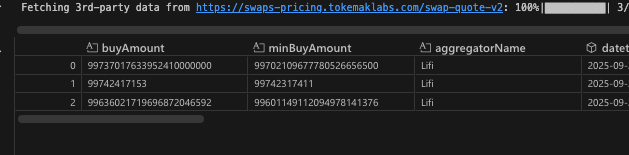

In [ ]:
df.columns

In [ ]:
# I have a feeling that the swap matrix is optimizing for the wrong thing, min buy amount vs buy amount?